# Сеть Хопфилда

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

import skimage.data
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize

np.random.seed(1)

class HopfieldNetwork:
        
    def train_weights(self, train_data):
        print("Начинаем обучение сети")
        num_data = len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        # инициализируем параметры модели
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        
        # правило Хэбба 
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += np.outer(t, t)
        
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W 
    
    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Процесс прогнозирования")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn
        
        copied_data = np.copy(data)
        
        predicted = []
        for i in tqdm(range(len(data))):
            predicted.append(self._run(copied_data[i]))
        return predicted
    
    def _run(self, init_s):
        # Синхронное обновление
        if not self.asyn:
            # Вычисляем начальное энергетическое состояние
            s = init_s

            e = self.energy(s)
            
            for i in range(self.num_iter):
                # Обновляем s
                s = np.sign(self.W @ s - self.threshold)
                # Вычисляем новое энергетическое состояние
                e_new = self.energy(s)
                
                # s сходится ?
                if e == e_new:
                    return s
                # обновляем энергетическое состояние
                e = e_new
            return s
        # Асинхронное обновление
        else:
            # Вычисляем начальное энергетическое состояние
            s = init_s
            e = self.energy(s)
            
            for i in range(self.num_iter):
                for j in range(100):
                    # Случайным образом выбираем нейрон
                    idx = np.random.randint(0, self.num_neuron) 
                    # Обновляем s
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)
                
                # Вычисляем новое энергетическое состояние
                e_new = self.energy(s)
                
                # s сходится ?
                if e == e_new:
                    return s
                # Обновляем энергетическое состояние
                e = e_new
            return s
    
    
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Параметры нейросетевой модели")
        plt.tight_layout()
        plt.savefig("ПараметрыСети.png")
        plt.show()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Предварительная обработка изображений
Начинаем обучение сети


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Процесс прогнозирования


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


Прогноз на тестовых данных


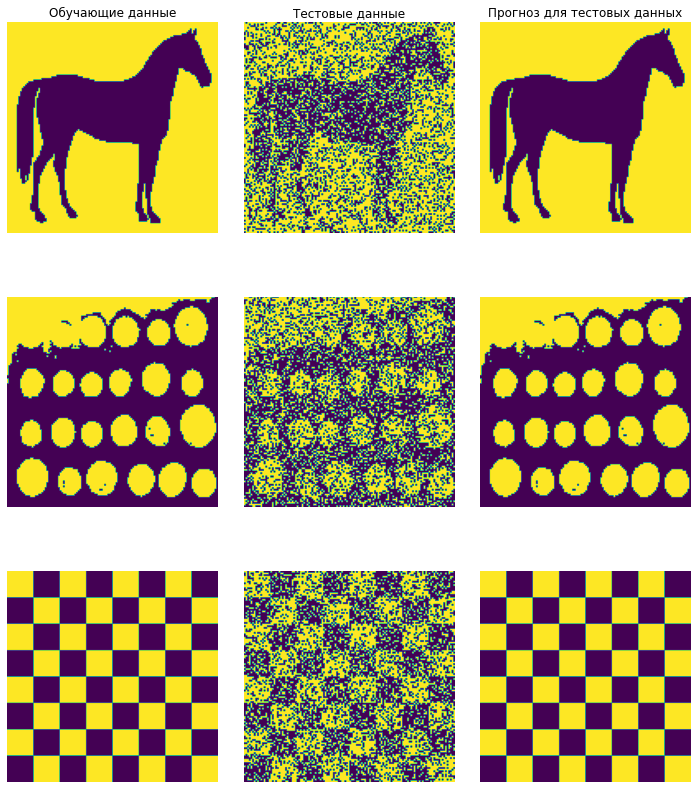

Матрица параметров сети


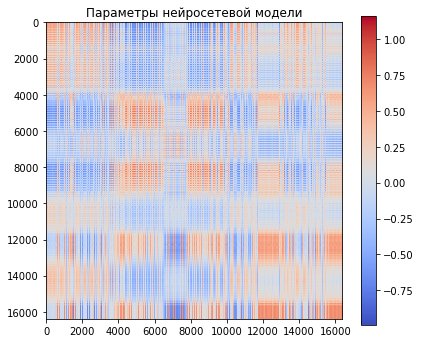

In [3]:
def get_corrupted_input(input_image, corruption_level):
    corrupted = np.copy(input_image)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input_image))
    for i, v in enumerate(input_image):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(10, 12)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]

    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[i, 0].set_title('Обучающие данные')
            axarr[i, 1].set_title("Тестовые данные")
            axarr[i, 2].set_title('Прогноз для тестовых данных')

        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig("result.png")
    plt.show()

def preprocessing(img, w=128, h=128):
    # Меняем размер изображения
    img = resize(img, (w,h), mode='reflect')

    # Применяем маску с пороговым значением (средним)
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1

    # Переводим матрицу изображения в одномерный вектор
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    # Загружаем данные
    horse = skimage.data.horse()
    coins = rgb2gray(skimage.data.coins())
    checkerboard = rgb2gray(skimage.data.checkerboard())

    data = [horse, coins, checkerboard]

    # Проводим предварительную обработку изображний
    print("Предварительная обработка изображений")
    data = [preprocessing(d) for d in data]

    # Создаем модель сети Хопфилда
    model = HopfieldNetwork()
    model.train_weights(data)

    # Генерируем тестовый набор данных
    test = [get_corrupted_input(d, 0.3) for d in data]

    predicted = model.predict(test, threshold=0, asyn=False)
    print("Прогноз на тестовых данных")
    plot(data, test, predicted)
    print("Матрица параметров сети")
    model.plot_weights()

if __name__ == '__main__':
    main()

# Многослойный перцептрон

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

feature_vector_length = 784
num_classes = 10

# Загружаем данные
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Переводим данные к необходимой размерности - одномерному вектору
X_train = X_train.reshape(X_train.shape[0], feature_vector_length)
X_test = X_test.reshape(X_test.shape[0], feature_vector_length)

# Конвертируем изображения в монохромные
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Конвертируем целевую переменную в категорильную
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

# Устанавливаем размер входного вектора
input_shape = (feature_vector_length,)
print(f'Размер входного вектора: {input_shape}')

# Создаем последовательную модель
model = Sequential()
model.add(Dense(350, input_shape=input_shape, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Компилируем модель и запускаем процесс обучения
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.2)

# Проверяем метрику качества на тестовых данных после обучения
test_results = model.evaluate(X_test, Y_test, verbose=1)
print(f'Результаты прогнозирования - Ошибка (Loss): {test_results[0]} - Точность (Accuracy): {test_results[1]}')


Размер входного вектора: (784,)
Epoch 1/10
192/192 [==============================] - 4s 13ms/step - loss: 0.3723 - accuracy: 0.8969 - val_loss: 0.1788 - val_accuracy: 0.9461
Epoch 2/10
192/192 [==============================] - 2s 13ms/step - loss: 0.1464 - accuracy: 0.9575 - val_loss: 0.1322 - val_accuracy: 0.9605
Epoch 3/10
192/192 [==============================] - 3s 14ms/step - loss: 0.0991 - accuracy: 0.9709 - val_loss: 0.1075 - val_accuracy: 0.9671
Epoch 4/10
192/192 [==============================] - 3s 13ms/step - loss: 0.0710 - accuracy: 0.9791 - val_loss: 0.0883 - val_accuracy: 0.9735
Epoch 5/10
192/192 [==============================] - 2s 12ms/step - loss: 0.0527 - accuracy: 0.9845 - val_loss: 0.0917 - val_accuracy: 0.9725
Epoch 6/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0411 - accuracy: 0.9882 - val_loss: 0.0886 - val_accuracy: 0.9736
Epoch 7/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0306 - accuracy: 0.9912 - val_los

# Цепь Маркова

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

# Построим простую модель предсказания погоды на неделю

# Холодному дню сопоставим индекс 0, жаркому - 1
# Предположим, что первый день недели будет холодным с вероятностью 0.8 (соответственно, жаркий - с вероятностью 0.2)
# Смоделируем это с помощью категориального распределения:

initial_distribution = tfd.Categorical(probs=[0.8, 0.2])

# Предположим, что холодный день может сменится жарким с вероятностью 30% (и с вероятностью 70% останется холодным)
# а жаркий день сменится на холодный с вероятностью 20% (и с вероятностью 80% останется жарким)
# Мы можем смоделировать это следующим образом:

transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])

# Дополнительно предположим, что каждый холодный день температура
# определяется нормальным распределением со средним значением 0 и стандартным отклонением 5,
# а каждый жаркий день - со средним значением 15 и стандартным отклонением 10
# Мы можем смоделировать это следующим образом:

observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

# Построим скрытую марковскую модель на основе определенных выше распределениях:

model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

# Математическое ожидание температуры для каждого дня недели выглядит следующим образом:
days = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
predictions = [day + " - " + str(round(temp, 2)) + " C" for day, temp in zip(days, model.mean().numpy())]
print(f"Математическое ожидание температуры для каждого дня недели выглядит следующим образом: \n{predictions}")



Математическое ожидание температуры для каждого дня недели выглядит следующим образом: 
['Понедельник - 3.0 C', 'Вторник - 6.0 C', 'Среда - 7.5 C', 'Четверг - 8.25 C', 'Пятница - 8.62 C', 'Суббота - 8.81 C', 'Воскресенье - 8.91 C']


# Машина Больцмана

In [6]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn import datasets
from sklearn.preprocessing import minmax_scale
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

X, Y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X = minmax_scale(X, feature_range=(0, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)



model_rbm = BernoulliRBM(n_components=100)
logistic = LogisticRegression()

rbm_features_classifier = Pipeline(steps=[("rbm", model_rbm), ("logistic", logistic)])
rbm_features_classifier.fit(X_train, Y_train)

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Логистическая регрессия, обученная на признаках, извлеченных с помощью ограниченной машины Больцмана:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Логистическая регрессия, обученная на признаках, извлеченных с помощью ограниченной машины Больцмана:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.83      0.86      0.85        35
           2       0.97      0.86      0.91        36
           3       0.77      0.93      0.84        29
           4       1.00      0.97      0.98        30
           5       0.93      0.93      0.93        40
           6       1.00      0.98      0.99        44
           7       0.86      0.97      0.92        39
           8       0.94      0.85      0.89        39
           9       0.82      0.78      0.80        41

    accuracy                           0.91       360
   macro avg       0.91      0.91      0.91       360
weighted avg       0.91      0.91      0.91       360




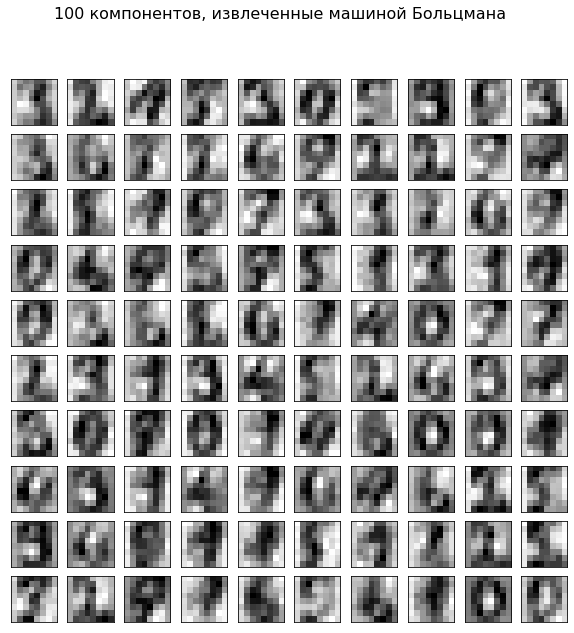

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, comp in enumerate(model_rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 компонентов, извлеченные машиной Больцмана", fontsize=16)
# plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# Глубокая сеть доверия

In [8]:
from utils.deep_belief_network.dbn.tensorflow import SupervisedDBNClassification
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import minmax_scale

X, Y = load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


classifier = SupervisedDBNClassification(hidden_layers_structure = [256, 256],
                                        learning_rate_rbm=0.05,
                                        learning_rate=0.1,
                                        n_epochs_rbm=10,
                                        n_iter_backprop=100,
                                        batch_size=32,
                                        activation_function='relu',
                                        dropout_p=0.2)

classifier.fit(X_train, Y_train)

Y_pred = classifier.predict(X_test)
print('Обучение модели завершено.\nТочность (Accuracy) на тестовом наборе данных: %f' % accuracy_score(Y_test, Y_pred))



Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `tf.cast` instead.
>> Эпоха 1 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 3.306404
>> Эпоха 2 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 2.243559
>> Эпоха 3 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 1.849163
>> Эпоха 4 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 1.670740
>> Эпоха 5 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 1.430362
>> Эпоха 6 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 1.315761
>> Эпоха 7 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 1.256606
>> Эпоха 8 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 1.135292
>> Эпоха 9 завершена 	 ошибка реконструкции данных Ограниченной машиной Больцмана 1.080016
>> Эпоха 10 завершена 	 ошибка реконструкции д

>> Эпоха 82 окончена 	ошибка модели на обучающем датасете 0.033804
>> Эпоха 83 окончена 	ошибка модели на обучающем датасете 0.031922
>> Эпоха 84 окончена 	ошибка модели на обучающем датасете 0.033068
>> Эпоха 85 окончена 	ошибка модели на обучающем датасете 0.035217
>> Эпоха 86 окончена 	ошибка модели на обучающем датасете 0.031990
>> Эпоха 87 окончена 	ошибка модели на обучающем датасете 0.031961
>> Эпоха 88 окончена 	ошибка модели на обучающем датасете 0.036609
>> Эпоха 89 окончена 	ошибка модели на обучающем датасете 0.037074
>> Эпоха 90 окончена 	ошибка модели на обучающем датасете 0.032556
>> Эпоха 91 окончена 	ошибка модели на обучающем датасете 0.036732
>> Эпоха 92 окончена 	ошибка модели на обучающем датасете 0.028454
>> Эпоха 93 окончена 	ошибка модели на обучающем датасете 0.033526
>> Эпоха 94 окончена 	ошибка модели на обучающем датасете 0.026943
>> Эпоха 95 окончена 	ошибка модели на обучающем датасете 0.029673
>> Эпоха 96 окончена 	ошибка модели на обучающем датасете 0.03

# Глубокая сверточная сеть

Размерность данных из обучающего набора данных : (60000, 28, 28), (60000,)
Размерность данных из тестового набора данных :  (10000, 28, 28), (10000,)
Количество экземпляров в обучающем наборе данных : 10
Количество классов объектов для предсказания : [0 1 2 3 4 5 6 7 8 9]
Истинная метка класса: 9
Метка после быстрого (one-hot) кодирования: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Описание построенной модели сверточной нейронной сети
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                      

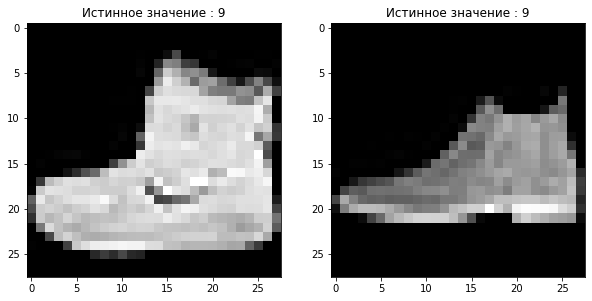

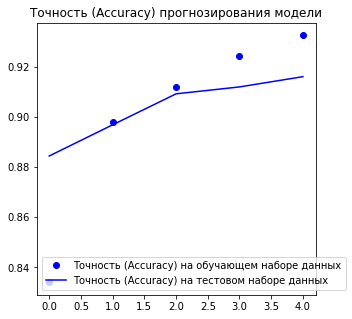

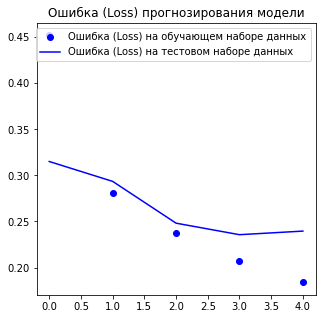

In [11]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print(f"Размерность данных из обучающего набора данных : {train_X.shape}, {train_Y.shape}")

print(f"Размерность данных из тестового набора данных :  {test_X.shape}, {test_Y.shape}")

# Узнаем количество уникальных меток классов объектов
classes = np.unique(train_Y)
nClasses = len(classes)
print(f"Количество экземпляров в обучающем наборе данных : {nClasses}")
print(f"Количество классов объектов для предсказания : {classes}")

plt.figure(figsize=[10,10])

# Отобразим первое изображение в обучающем наборе данных
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title(f"Истинное значение : {train_Y[0]}")

# Отобразим первое изображение в тестовом наборе данных
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title(f"Истинное значение : {test_Y[0]}")

train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Поменяем категорильные метки классов на быстрое кодирование (one-hot encoding)
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

print('Истинная метка класса:', train_Y[0])
print('Метка после быстрого (one-hot) кодирования:', train_Y_one_hot[0])

from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU

batch_size = 64
epochs = 5
num_classes = 10

fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

fashion_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])

print("Описание построенной модели сверточной нейронной сети")
print(fashion_model.summary())

fashion_train = fashion_model.fit(train_X,
                                  train_label,
                                  batch_size=batch_size,
                                  epochs=epochs
                                  ,verbose=1,
                                  validation_data=(valid_X, valid_label))

test_eval = fashion_model.evaluate(test_X,
                                   test_Y_one_hot,
                                   verbose=0)

print(f"Ошибка (Loss) на тестовой выборке - {test_eval[0]}")
print(f"Точность (Accuracy) на тестовой выборке - {test_eval[1]}")

accuracy = fashion_train.history['acc']
val_accuracy = fashion_train.history['val_acc']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.figure(figsize=[5,5])
plt.plot(epochs, accuracy, 'bo', label='Точность (Accuracy) на обучающем наборе данных')
plt.plot(epochs, val_accuracy, 'b', label='Точность (Accuracy) на тестовом наборе данных')
plt.title('Точность (Accuracy) прогнозирования модели')
plt.legend()
plt.figure(figsize=[5,5])
plt.plot(epochs, loss, 'bo', label='Ошибка (Loss) на обучающем наборе данных')
plt.plot(epochs, val_loss, 'b', label='Ошибка (Loss) на тестовом наборе данных')
plt.title('Ошибка (Loss) прогнозирования модели')
plt.legend()
plt.show()

# Капсульная сеть

In [3]:
# смотрите в репозитории

# Трансформеры

In [2]:
!pip install pytorch-transformers

You should consider upgrading via the 'd:\apps\python38\python.exe -m pip install --upgrade pip' command.



  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895257 sha256=5946bc3b3f1422e068cbd181ab07cadd2752b3b1a9cabb5e243ea6f1ff553392
  Stored in directory: c:\users\malov\appdata\local\pip\cache\wheels\82\ab\9b\c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [6]:
import torch
from pytorch_transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Encode a text inputs
text = "Hi! My name is Dmitrii Malov and I'm excited to be here."
indexed_tokens = tokenizer.encode(text)

# Convert indexed tokens in a PyTorch tensor
tokens_tensor = torch.tensor([indexed_tokens])

# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set the model in evaluation mode to deactivate the DropOut modules
model.eval()

# If you have a GPU, put everything on cuda
# tokens_tensor = tokens_tensor.to('cuda')
# model.to('cuda')

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]

# Get the predicted next sub-word
predicted_index = torch.argmax(predictions[0, -1, :]).item()
predicted_text = tokenizer.decode(indexed_tokens + [predicted_index])

# Print the predicted word
print(predicted_text)

 Hi! My name is Dmitrii Malov and I'm excited to be here. I


# Рекуррентные нейронные сети (с LSTM блоком)

  8%|█████▍                                                           | 45983744/548118077 [12:30<2:16:30, 61306.93B/s]


Epoch 1/100
94/94 - 2s - loss: 0.0363 - 2s/epoch - 19ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0167 - 174ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0128 - 165ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0114 - 161ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0106 - 164ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0096 - 156ms/epoch - 2ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0086 - 163ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0077 - 165ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0068 - 157ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0059 - 155ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0051 - 162ms/epoch - 2ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0045 - 158ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0039 - 162ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0034 - 157ms/epoch - 2ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0030 - 164ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0027 - 153ms/epoc

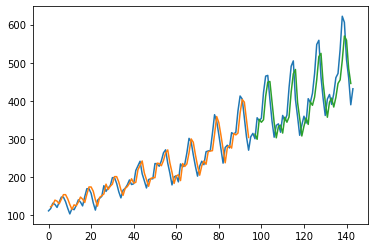

In [8]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Автокодировщики

(60000, 784)
(10000, 784)
Epoch 1/100
235/235 [==============================] - 2s 6ms/step - loss: 0.2796 - val_loss: 0.1848
Epoch 2/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1674 - val_loss: 0.1519
Epoch 3/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1435 - val_loss: 0.1335
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1288 - val_loss: 0.1222
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1189 - val_loss: 0.1135
Epoch 6/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1118 - val_loss: 0.1074
Epoch 7/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1065 - val_loss: 0.1030
Epoch 8/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1026 - val_loss: 0.0998
Epoch 9/100
235/235 [==============================] - 2s 8ms/step - loss: 0.0999 - val_loss: 0.0975
Epoch 10/100
235/235 [==============================] - 2s 7ms/st

235/235 [==============================] - 2s 8ms/step - loss: 0.0926 - val_loss: 0.0916
Epoch 82/100
235/235 [==============================] - 2s 8ms/step - loss: 0.0926 - val_loss: 0.0915
Epoch 83/100
235/235 [==============================] - 1s 6ms/step - loss: 0.0926 - val_loss: 0.0915
Epoch 84/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0926 - val_loss: 0.0915
Epoch 85/100
235/235 [==============================] - 2s 6ms/step - loss: 0.0926 - val_loss: 0.0915
Epoch 86/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0925 - val_loss: 0.0915
Epoch 87/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0926 - val_loss: 0.0915
Epoch 88/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0925 - val_loss: 0.0915
Epoch 89/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0926 - val_loss: 0.0915
Epoch 90/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0925 - val_loss: 

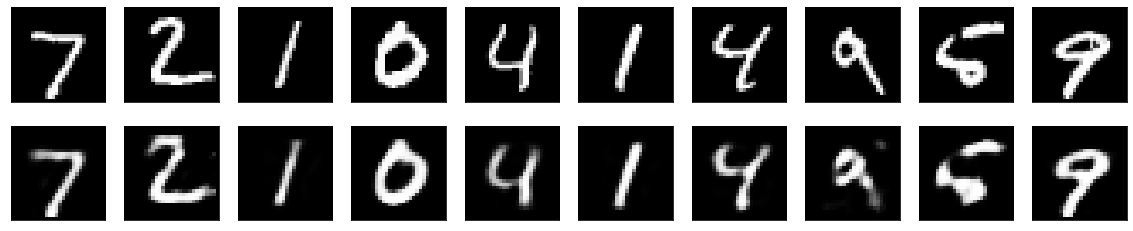

In [13]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)


# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Сверточный автокодировщик

In [14]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
!tensorboard --logdir=/tmp/autoencoder

^C


Epoch 1/50
469/469 [==============================] - 48s 101ms/step - loss: 0.1348 - val_loss: 0.1269
Epoch 2/50
469/469 [==============================] - 60s 127ms/step - loss: 0.1233 - val_loss: 0.1188
Epoch 3/50
469/469 [==============================] - 59s 125ms/step - loss: 0.1164 - val_loss: 0.1126
Epoch 4/50
469/469 [==============================] - 60s 128ms/step - loss: 0.1119 - val_loss: 0.1088
Epoch 5/50
469/469 [==============================] - 68s 144ms/step - loss: 0.1086 - val_loss: 0.1061
Epoch 6/50
469/469 [==============================] - 62s 132ms/step - loss: 0.1062 - val_loss: 0.1039
Epoch 7/50
469/469 [==============================] - 60s 128ms/step - loss: 0.1043 - val_loss: 0.1019
Epoch 8/50
469/469 [==============================] - 63s 135ms/step - loss: 0.1028 - val_loss: 0.1009
Epoch 9/50
469/469 [==============================] - 59s 125ms/step - loss: 0.1015 - val_loss: 0.1005
Epoch 10/50
469/469 [==============================] - 58s 124ms/step - l

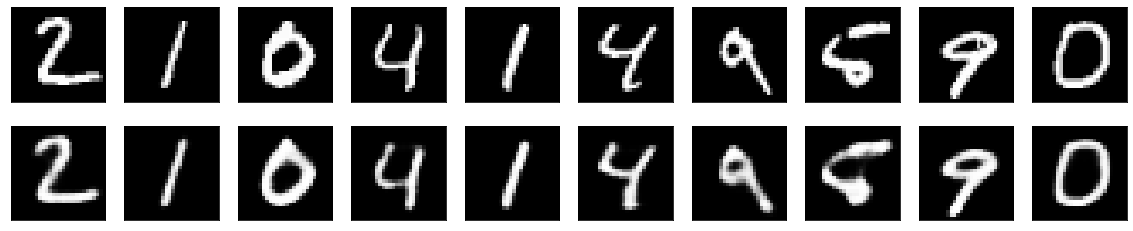

In [19]:
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='D:/projects/DL-book/code/tmp/autoencoder')])

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Генеративно-состязательные сети

In [ ]:
"([]){}"

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])